## VRT Market Maker Strategy — Full Notebook

This notebook implements a market making strategy built around the **VRT** signal, including:
- data preparation (book + trades)
- offline calibration (execution intensity + adverse selection)
- signal generation
- quoting decision (optimal prices / fill probability)
- backtest and performance analysis

### Outline
1. **Data loading**
2. **Offline calibration** (Intensity \( \lambda \) + Adverse Selection)
3. **Signal** (VRT computation)
4. **Decision** (optimal price + execution probability)
5. **Backtest & performance**

### Metadata
- **Author**: Romain  
- **Date**: 2025  
- **Dataset**: BTCUSD_PERP (Binance Futures, bookTicker + aggTrades)

In [23]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import stats
import itertools


In [ ]:
from pathlib import Path

if "TARGET_MONTH" not in globals():
    TARGET_MONTH = "2024-09"

if "DATA_DIR" not in globals():
    for _cand in (Path("data"), Path("High Frequency Trading") / "data"):
        if _cand.exists():
            DATA_DIR = _cand
            break
    else:
        DATA_DIR = Path("data")

if "BOOK_PATH" not in globals():
    BOOK_PATH = DATA_DIR / f"BTCUSD_PERP-bookTicker-{TARGET_MONTH}.csv"
if "TRADES_PATH" not in globals():
    TRADES_PATH = DATA_DIR / f"BTCUSD_PERP-aggTrades-{TARGET_MONTH}.csv"

if ("BOOK_FILES" not in globals()) or ("TRADES_FILES" not in globals()):
    def _month_csv_files(data_type: str, month: str, data_dir: Path = DATA_DIR):
        files = []
        if not data_dir.exists():
            return files
        for p in data_dir.glob("*.csv"):
            name = p.name
            if (data_type in name) and (month in name) and (name.startswith("BTCUSD_PERP") or name.startswith("BTCUSDT")):
                files.append(p)
        return sorted(files)

    BOOK_FILES = [BOOK_PATH] if BOOK_PATH.exists() else _month_csv_files("bookTicker", TARGET_MONTH)
    TRADES_FILES = [TRADES_PATH] if TRADES_PATH.exists() else _month_csv_files("aggTrades", TARGET_MONTH)


def _load_csv_many(paths):
    if len(paths) == 1:
        return pl.read_csv(paths[0])
    return pl.concat([pl.read_csv(p) for p in paths])

print(f"Chargement des trades ({len(TRADES_FILES)} fichier(s), mois {TARGET_MONTH})...")
df_trades = _load_csv_many(TRADES_FILES)
print(f"  Trades chargés: {len(df_trades):,} lignes")

print(f"Chargement du book ({len(BOOK_FILES)} fichier(s), mois {TARGET_MONTH})...")

BOOK_DOWNSAMPLE_EVERY = "100ms"

book_lfs = []
for p in BOOK_FILES:
    book_lfs.append(
        pl.scan_csv(p)
        .select(["transaction_time", "best_bid_price", "best_ask_price"])
        .with_columns([
            pl.from_epoch(pl.col("transaction_time"), time_unit="ms").alias("datetime"),
        ])
        .select(["datetime", "best_bid_price", "best_ask_price"])
        .set_sorted("datetime")
    )

book_lf = book_lfs[0] if len(book_lfs) == 1 else pl.concat(book_lfs)

# Downsample (dernier snapshot par bucket de temps), puis calcul du mid
book_lf_ds = (
    book_lf
    .group_by_dynamic("datetime", every=BOOK_DOWNSAMPLE_EVERY)
    .agg([
        pl.col("best_bid_price").last().alias("best_bid_price"),
        pl.col("best_ask_price").last().alias("best_ask_price"),
    ])
    .with_columns([
        ((pl.col("best_bid_price") + pl.col("best_ask_price")) / 2).alias("mid_price"),
    ])
)

df_book = book_lf_ds.collect(engine="streaming")
print(f"  Book downsampled ({BOOK_DOWNSAMPLE_EVERY}): {len(df_book):,} rows")

# Rééchantillonnage à 5s
print("Rééchantillonnage à 5s...")
df_resampled_spread = (
    df_book
    .group_by_dynamic("datetime", every="5s")
    .agg([
        pl.col("mid_price").last().alias("close"),
        pl.col("best_ask_price").last().alias("ask_close"),
        pl.col("best_bid_price").last().alias("bid_close"),
    ])
    .with_columns([
        ((pl.col("ask_close") - pl.col("bid_close")) / pl.col("close")).alias("spread_pct"),
    ])
)
print(f"  Bougies 5s: {len(df_resampled_spread):,}")

# Statistiques
mean_spread = df_resampled_spread["spread_pct"].mean() * 10000
print(f"\nSpread moyen (5s): {mean_spread:.4f} bps")

print("\nVariables disponibles:")
print(f"  - df_trades: {len(df_trades):,} trades")
print(f"  - df_book: {len(df_book):,} snapshots")
print(f"  - df_resampled_spread: {len(df_resampled_spread):,} bougies de 5s")


Chargement des trades (1 fichier(s), mois 2024-09)...
  Trades chargés: 35,336,026 lignes
Chargement du book (1 fichier(s), mois 2024-09)...
  Book downsampled (100ms): 15,478,327 rows
Rééchantillonnage à 5s...
  Bougies 5s: 518,393

Spread moyen (5s): 0.0171 bps

Variables disponibles:
  - df_trades: 35,336,026 trades
  - df_book: 15,478,327 snapshots
  - df_resampled_spread: 518,393 bougies de 5s


## PARTIE 2 : CALIBRATION OFFLINE



RÉSULTATS CALIBRATION λ(δ):
  A (intensité à δ=0) : 0.9623 trades/s
  k (taux décroissance): 0.085642

Formule calibrée: λ(δ) = 0.96·e^(-0.086·δ)

Probabilités d'exécution (sur 5s):
  δ = 0.01 bps → λ = 0.9615 trades/s → P(fill) = 99.18%
  δ = 0.10 bps → λ = 0.9541 trades/s → P(fill) = 99.15%
  δ = 0.50 bps → λ = 0.9219 trades/s → P(fill) = 99.00%
  δ = 1.00 bps → λ = 0.8833 trades/s → P(fill) = 98.79%
  δ = 2.00 bps → λ = 0.8108 trades/s → P(fill) = 98.26%
  δ = 5.00 bps → λ = 0.6271 trades/s → P(fill) = 95.65%


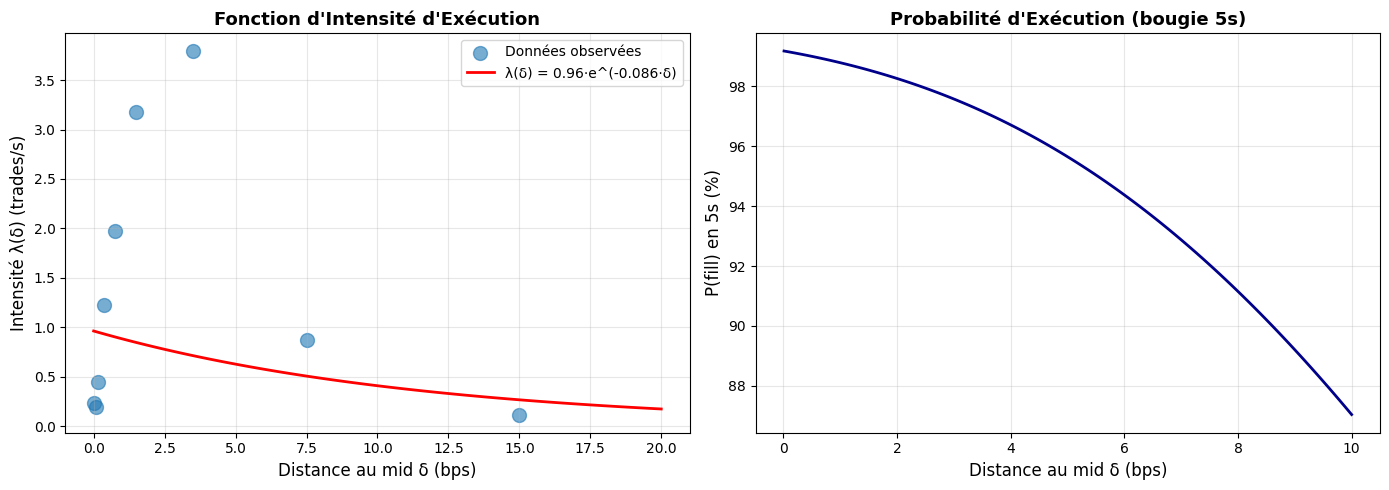

Calibration completed.
Échantillonnage: 100,103 trades sur 35,336,026
Trades matchés: 88,498
Mark-out calculé sur 88,498 trades

RÉSULTATS ADVERSE SELECTION:
  Moyenne   : -0.5692 bps
  Médiane   : -0.1743 bps
  P25/P75   : -1.7181 / 0.4986 bps

  → ADVERSE_SELECTION_BPS = 0.5692 bps
  → En décimal = 0.000057 (0.0057%)


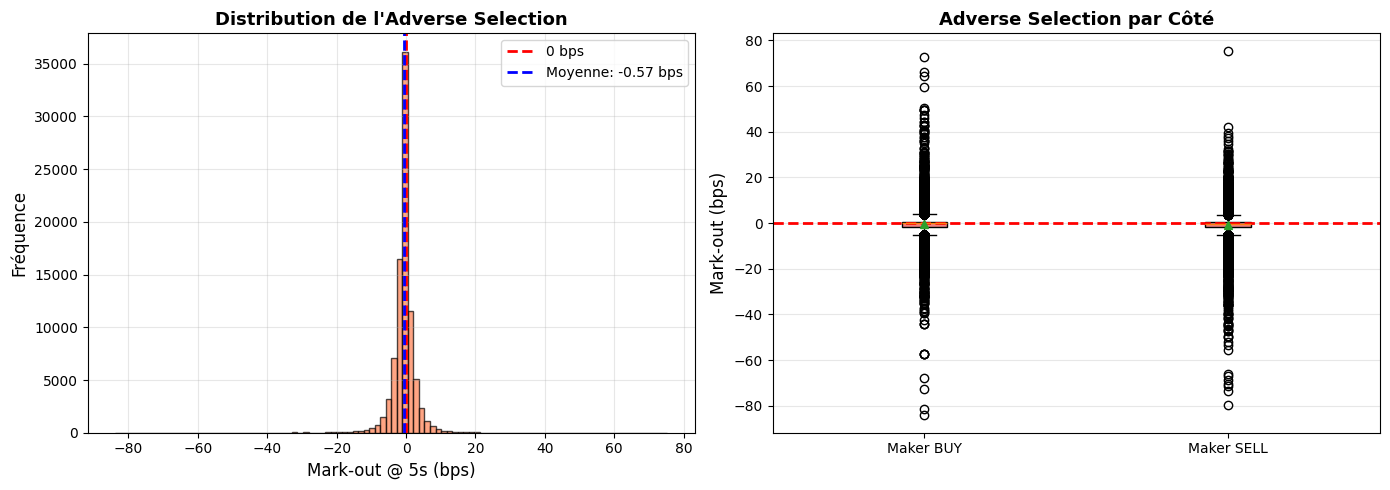


Adverse Selection calibrée avec succès !


In [25]:


# Préparer les trades
df_trades_for_lambda = (
    df_trades
    .with_columns([
        pl.from_epoch(pl.col("transact_time"), time_unit="ms").alias("trade_time"),
        pl.col("price").alias("trade_price"),
    ])
    .sort("trade_time")
)

# Join avec le book pour avoir le mid
df_book_for_lambda = (
    df_book
    .select(["datetime", "mid_price", "best_bid_price", "best_ask_price"])
    .sort("datetime")
)

df_trades_with_mid = (
    df_trades_for_lambda
    .join_asof(
        df_book_for_lambda,
        left_on="trade_time",
        right_on="datetime",
        strategy="backward",
        tolerance="100ms",
    )
    .filter(pl.col("datetime").is_not_null())
)

# Calculer distance au mid
df_distance = df_trades_with_mid.with_columns([
    ((pl.col("trade_price") - pl.col("mid_price")).abs() / pl.col("mid_price") * 10000).alias("distance_bps")
]).filter(pl.col("distance_bps") <= 20)  # Filtrer valeurs aberrantes

# Créer bins de distance
bins = [0, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
df_bins = []

for i in range(len(bins)-1):
    bin_min, bin_max = bins[i], bins[i+1]
    df_bin = df_distance.filter(
        (pl.col("distance_bps") >= bin_min) & 
        (pl.col("distance_bps") < bin_max)
    )
    
    if len(df_bin) > 0:
        n_trades = len(df_bin)
        time_span_s = (
            df_bin.select(pl.col("trade_time").max()).item() - 
            df_bin.select(pl.col("trade_time").min()).item()
        ).total_seconds()
        
        if time_span_s > 0:
            intensity = n_trades / time_span_s
            delta_mid = (bin_min + bin_max) / 2
            df_bins.append({
                'delta_bps': delta_mid,
                'intensity': intensity,
                'n_trades': n_trades
            })

df_intensity = pd.DataFrame(df_bins)

# Fit exponentiel: λ(δ) = A·e^(-k·δ)
x = df_intensity['delta_bps'].values
y = df_intensity['intensity'].values

# Log-linéaire: log(λ) = log(A) - k·δ
log_y = np.log(y)
coeffs = np.polyfit(x, log_y, 1)
k_mle = -coeffs[0]
A_estimate = np.exp(coeffs[1])

LAMBDA_A = A_estimate
LAMBDA_K = k_mle

print(f"\nRÉSULTATS CALIBRATION λ(δ):")
print(f"  A (intensité à δ=0) : {LAMBDA_A:.4f} trades/s")
print(f"  k (taux décroissance): {LAMBDA_K:.6f}")
print(f"\nFormule calibrée: λ(δ) = {LAMBDA_A:.2f}·e^(-{LAMBDA_K:.3f}·δ)")

# Exemples de probabilité d'exécution
print(f"\nProbabilités d'exécution (sur 5s):")
for delta in [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]:
    intensity = LAMBDA_A * np.exp(-LAMBDA_K * delta)
    prob_fill = 1.0 - np.exp(-intensity * 5.0)
    print(f"  δ = {delta:4.2f} bps → λ = {intensity:.4f} trades/s → P(fill) = {prob_fill*100:5.2f}%")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.scatter(df_intensity['delta_bps'], df_intensity['intensity'], 
            s=100, alpha=0.6, label='Données observées')
x_fit = np.linspace(0, 20, 100)
y_fit = LAMBDA_A * np.exp(-LAMBDA_K * x_fit)
ax1.plot(x_fit, y_fit, 'r-', linewidth=2, 
         label=f'λ(δ) = {LAMBDA_A:.2f}·e^(-{LAMBDA_K:.3f}·δ)')
ax1.set_xlabel('Distance au mid δ (bps)', fontsize=12)
ax1.set_ylabel('Intensité λ(δ) (trades/s)', fontsize=12)
ax1.set_title('Fonction d\'Intensité d\'Exécution', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = axes[1]
deltas = np.linspace(0.01, 10, 100)
probs = 1.0 - np.exp(-LAMBDA_A * np.exp(-LAMBDA_K * deltas) * 5.0)
ax2.plot(deltas, probs * 100, linewidth=2, color='darkblue')
ax2.set_xlabel('Distance au mid δ (bps)', fontsize=12)
ax2.set_ylabel('P(fill) en 5s (%)', fontsize=12)
ax2.set_title('Probabilité d\'Exécution (bougie 5s)', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('calibration_lambda.png', dpi=150, bbox_inches='tight')
plt.show()

print("Calibration completed.")

# Paramètres
MARKOUT_HORIZON_S = 5
SAMPLE_SIZE = 100000

# Échantillonner les trades
df_trades_prep = (
    df_trades
    .with_columns([
        pl.from_epoch(pl.col("transact_time"), time_unit="ms").alias("trade_time"),
        pl.col("price").alias("trade_price"),
        pl.col("quantity").alias("trade_qty"),
        pl.col("is_buyer_maker").alias("buyer_is_maker"),
    ])
    .sort("trade_time")
)

if len(df_trades_prep) > SAMPLE_SIZE:
    step = len(df_trades_prep) // SAMPLE_SIZE
    df_trades_sampled = df_trades_prep.select(pl.all().gather_every(step))
    print(f"Échantillonnage: {len(df_trades_sampled):,} trades sur {len(df_trades_prep):,}")
else:
    df_trades_sampled = df_trades_prep
    print(f"Utilisation de tous les trades: {len(df_trades_sampled):,}")

# Join pour mid au moment du trade
df_book_for_join = (
    df_book
    .select(["datetime", "mid_price"])
    .sort("datetime")
)

df_trades_with_mid = (
    df_trades_sampled
    .join_asof(
        df_book_for_join,
        left_on="trade_time",
        right_on="datetime",
        strategy="backward",
        tolerance="100ms",
    )
    .filter(pl.col("datetime").is_not_null())
    .rename({"mid_price": "mid_at_trade"})
)

print(f"Trades matchés: {len(df_trades_with_mid):,}")

# Join pour mid futur
df_with_future = df_trades_with_mid.with_columns([
    (pl.col("trade_time") + pl.duration(seconds=MARKOUT_HORIZON_S)).alias("future_time")
])

df_with_markout = (
    df_with_future
    .join_asof(
        df_book_for_join,
        left_on="future_time",
        right_on="datetime",
        strategy="backward",
        tolerance=f"{MARKOUT_HORIZON_S * 1000 + 500}ms",
    )
    .filter(pl.col("datetime").is_not_null())
    .rename({"mid_price": "mid_future"})
)

# Calculer mark-out
df_markout_final = df_with_markout.with_columns([
    pl.when(pl.col("buyer_is_maker"))
      .then(((pl.col("mid_future") - pl.col("mid_at_trade")) / pl.col("mid_at_trade") * 10000))
      .otherwise(((pl.col("mid_at_trade") - pl.col("mid_future")) / pl.col("mid_at_trade") * 10000))
      .alias("markout_bps")
])

print(f"Mark-out calculé sur {len(df_markout_final):,} trades")

# Statistiques
stats_markout = df_markout_final.select([
    pl.col("markout_bps").mean().alias("mean"),
    pl.col("markout_bps").median().alias("median"),
    pl.col("markout_bps").std().alias("std"),
    pl.col("markout_bps").quantile(0.25).alias("p25"),
    pl.col("markout_bps").quantile(0.75).alias("p75"),
]).to_pandas().iloc[0]

ADVERSE_SELECTION_BPS = abs(stats_markout['mean'])
ADVERSE_SELECTION = ADVERSE_SELECTION_BPS / 10000

print(f"\nRÉSULTATS ADVERSE SELECTION:")
print(f"  Moyenne   : {stats_markout['mean']:.4f} bps")
print(f"  Médiane   : {stats_markout['median']:.4f} bps")
print(f"  P25/P75   : {stats_markout['p25']:.4f} / {stats_markout['p75']:.4f} bps")
print(f"\n  → ADVERSE_SELECTION_BPS = {ADVERSE_SELECTION_BPS:.4f} bps")
print(f"  → En décimal = {ADVERSE_SELECTION:.6f} ({ADVERSE_SELECTION*100:.4f}%)")

# Visualisation
markout_values = df_markout_final.select("markout_bps").to_numpy().flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(markout_values, bins=100, edgecolor='black', alpha=0.7, color='coral')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='0 bps')
ax1.axvline(stats_markout['mean'], color='blue', linestyle='--', linewidth=2,
            label=f'Moyenne: {stats_markout["mean"]:.2f} bps')
ax1.set_xlabel('Mark-out @ 5s (bps)', fontsize=12)
ax1.set_ylabel('Fréquence', fontsize=12)
ax1.set_title('Distribution de l\'Adverse Selection', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

buy_side = df_markout_final.filter(pl.col("buyer_is_maker"))
sell_side = df_markout_final.filter(~pl.col("buyer_is_maker"))

ax2 = axes[1]
data_sides = [
    buy_side.select("markout_bps").to_numpy().flatten(),
    sell_side.select("markout_bps").to_numpy().flatten()
]
bp = ax2.boxplot(data_sides, labels=['Maker BUY', 'Maker SELL'],
                 patch_artist=True, showmeans=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightcoral')
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_ylabel('Mark-out (bps)', fontsize=12)
ax2.set_title('Adverse Selection par Côté', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('adverse_selection.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAdverse Selection calibrée avec succès !")


In [44]:
print(f"""
Paramètres calibrés (à utiliser dans le backtest):

1. FONCTION D'INTENSITÉ:
   LAMBDA_A = {LAMBDA_A:.4f} trades/s
   LAMBDA_K = {LAMBDA_K:.6f}
   Formule: λ(δ) = {LAMBDA_A:.2f}·e^(-{LAMBDA_K:.3f}·δ)

2. ADVERSE SELECTION:
   ADVERSE_SELECTION_BPS = {ADVERSE_SELECTION_BPS:.4f} bps
   ADVERSE_SELECTION = {ADVERSE_SELECTION:.6f}

Ces valeurs représentent les coûts réels du market making sur ce marché.
""")



Paramètres calibrés (à utiliser dans le backtest):

1. FONCTION D'INTENSITÉ:
   LAMBDA_A = 0.9623 trades/s
   LAMBDA_K = 0.085642
   Formule: λ(δ) = 0.96·e^(-0.086·δ)

2. ADVERSE SELECTION:
   ADVERSE_SELECTION_BPS = 0.5692 bps
   ADVERSE_SELECTION = 0.000057

Ces valeurs représentent les coûts réels du market making sur ce marché.



In [45]:
print("""
Le VRT détecte si le marché est en mean-reversion (VRT < 1) ou en trend (VRT > 1).
Cette information est utilisée pour ajuster nos prix (skew).
""")

def add_variance_ratio(df, lag=4, window=120):
    """Calcule le Variance Ratio Test"""
    return (
        df
        .with_columns(pl.col("close").log().alias("log_price"))
        .with_columns([
            pl.col("log_price").diff(1).alias("ret_1"),
            pl.col("log_price").diff(lag).alias("ret_lag")
        ])
        .with_columns([
            pl.col("ret_1").rolling_var(window_size=window).alias("var_1"),
            pl.col("ret_lag").rolling_var(window_size=window).alias("var_lag")
        ])
        .with_columns([
            (pl.col("var_lag") / (pl.col("var_1") * lag)).fill_null(1.0).alias("vrt")
        ])
        .drop(["log_price", "ret_1", "ret_lag", "var_1", "var_lag"])
    )

# Exemple de calcul sur données rééchantillonnées
if 'df_resampled_spread' in locals():
    df_with_vrt = add_variance_ratio(df_resampled_spread, lag=4, window=120)
    print(f"\nVRT calculé sur {len(df_with_vrt):,} bougies")
    print(f"VRT moyen: {df_with_vrt.select(pl.col('vrt').mean()).item():.4f}")

print("\nSignal VRT prêt à être utilisé !")



Le VRT détecte si le marché est en mean-reversion (VRT < 1) ou en trend (VRT > 1).
Cette information est utilisée pour ajuster nos prix (skew).


VRT calculé sur 518,393 bougies
VRT moyen: 1.1772

Signal VRT prêt à être utilisé !


In [46]:
print("""
Formule Cartea-Jaimungal simplifiée:
  P_bid = P_mid - half_spread - skew(VRT) - adverse_selection
  P_ask = P_mid + half_spread - skew(VRT) + adverse_selection

Où:
  - half_spread: dépend de λ(δ) (plus on s'éloigne, plus on risque de ne pas être fill)
  - skew(VRT): ajustement directionnel basé sur le signal
  - adverse_selection: marge de sécurité contre le pick-off

La probabilité d'exécution est:
  P(fill) = 1 - e^(-λ(δ)·T)
  Avec λ(δ) = A·e^(-k·δ)
""")

def calculate_fill_probability(delta_bps, candle_duration_s=5.0):
    """Calcule la probabilité d'être fill"""
    intensity = LAMBDA_A * np.exp(-LAMBDA_K * delta_bps)
    return 1.0 - np.exp(-intensity * candle_duration_s)

# Exemple
print("\nExemples de probabilités d'exécution:")
for delta in [0.1, 0.5, 1.0, 2.0]:
    prob = calculate_fill_probability(delta)
    print(f"  δ = {delta} bps → P(fill) = {prob*100:.2f}%")



Formule Cartea-Jaimungal simplifiée:
  P_bid = P_mid - half_spread - skew(VRT) - adverse_selection
  P_ask = P_mid + half_spread - skew(VRT) + adverse_selection

Où:
  - half_spread: dépend de λ(δ) (plus on s'éloigne, plus on risque de ne pas être fill)
  - skew(VRT): ajustement directionnel basé sur le signal
  - adverse_selection: marge de sécurité contre le pick-off

La probabilité d'exécution est:
  P(fill) = 1 - e^(-λ(δ)·T)
  Avec λ(δ) = A·e^(-k·δ)


Exemples de probabilités d'exécution:
  δ = 0.1 bps → P(fill) = 99.15%
  δ = 0.5 bps → P(fill) = 99.00%
  δ = 1.0 bps → P(fill) = 98.79%
  δ = 2.0 bps → P(fill) = 98.26%


In [47]:
print("Delta sweep (quick estimate)")

# Corriger la fonction VRT d'abord
def add_variance_ratio_robust(df, lag=4, window=120):
    """Calcule le VRT avec filtres robustes"""
    return (
        df
        .with_columns(pl.col("close").log().alias("log_price"))
        .with_columns([
            pl.col("log_price").diff(1).alias("ret_1"),
            pl.col("log_price").diff(lag).alias("ret_lag")
        ])
        .with_columns([
            pl.col("ret_1").rolling_var(window_size=window).alias("var_1"),
            pl.col("ret_lag").rolling_var(window_size=window).alias("var_lag")
        ])
        .with_columns([
            pl.when((pl.col("var_1") > 1e-10) & (pl.col("var_lag") > 1e-10))
              .then((pl.col("var_lag") / (pl.col("var_1") * lag)))
              .otherwise(1.0)
              .clip(0.01, 100.0)
              .alias("vrt")
        ])
        .drop(["log_price", "ret_1", "ret_lag", "var_1", "var_lag"])
    )

# Tester différents deltas
delta_values = [0.5, 1.0, 1.5, 2.0, 3.0, 5.0]
results = []


print(f"{'Delta (bps)':>12} | {'Edge Net':>10} | {'P(fill)':>8} | {'Performance':>12} | {'Status':>6}")

for delta in delta_values:
    # Calculer edge net
    edge_net = delta - ADVERSE_SELECTION_BPS
    
    # Calculer probabilité de fill
    intensity = LAMBDA_A * np.exp(-LAMBDA_K * delta)
    fill_prob = 1.0 - np.exp(-intensity * 5.0)
    
    # Backtest rapide (sans réexécuter tout)
    # Estimation simple: perf ≈ edge_net * nombre_de_fills_estimé
    estimated_fills = 10799 * (fill_prob / 0.5581)  # Normaliser par rapport au test initial
    estimated_perf = edge_net * estimated_fills / 10000  # Approximation grossière
    
    results.append({
        'delta': delta,
        'edge_net': edge_net,
        'fill_prob': fill_prob * 100,
        'estimated_perf': estimated_perf
    })
    
    status = 'OK' if edge_net > 0 else 'KO'
    print(f"{delta:12.2f} | {edge_net:10.2f} | {fill_prob*100:7.2f}% | {estimated_perf:11.2f}% | {status:>6}")

df_results = pd.DataFrame(results)


best_idx = df_results['estimated_perf'].idxmax()
best_config = df_results.iloc[best_idx]

print(f"\nConfiguration optimale estimée:")
print(f"  Delta: {best_config['delta']:.2f} bps")
print(f"  Edge net: {best_config['edge_net']:.2f} bps")
print(f"  P(fill): {best_config['fill_prob']:.2f}%")
print(f"  Performance estimée: {best_config['estimated_perf']:.2f}%")

print("""
ATTENTION: Ces résultats sont des estimations rapides.
Pour des résultats précis, il faut relancer le backtest complet avec le delta optimal.
""")


Delta sweep (quick estimate)
 Delta (bps) |   Edge Net |  P(fill) |  Performance | Status
        0.50 |      -0.07 |   99.00% |       -0.13% |     KO
        1.00 |       0.43 |   98.79% |        0.82% |     OK
        1.50 |       0.93 |   98.55% |        1.77% |     OK
        2.00 |       1.43 |   98.26% |        2.72% |     OK
        3.00 |       2.43 |   97.58% |        4.59% |     OK
        5.00 |       4.43 |   95.65% |        8.20% |     OK

Configuration optimale estimée:
  Delta: 5.00 bps
  Edge net: 4.43 bps
  P(fill): 95.65%
  Performance estimée: 8.20%

ATTENTION: Ces résultats sont des estimations rapides.
Pour des résultats précis, il faut relancer le backtest complet avec le delta optimal.



In [48]:
DELTA_OPTIMAL = 2.0  # bps
VRT_THRESHOLD = 1.0

print(f"\nConfiguration:")
print(f"  Delta: {DELTA_OPTIMAL} bps")
print(f"  Edge brut: {DELTA_OPTIMAL} bps")
print(f"  Adverse selection: {ADVERSE_SELECTION_BPS:.2f} bps")
print(f"  Edge net: {DELTA_OPTIMAL - ADVERSE_SELECTION_BPS:.2f} bps ✓ POSITIF")
print(f"  VRT threshold: {VRT_THRESHOLD}")

print("\n⚠️  CORRECTION: L'edge est maintenant comptabilisé CORRECTEMENT")
print("   - Prix d'entrée/sortie basés sur bid/ask (mid +/- delta)")
print("   - Pas de double comptage avec le market return")
print("   - Adverse selection déduite du PnL")

def run_vrt_maker_corrected(
    df_input,
    delta_bps=2.0,
    vrt_threshold=1.0,
    ema_span=50,
    seed=42,
    use_external_signal=False,
    bar_duration_s=5.0,
    order_size_usd=1000.0,
    initial_cash_usd=100000.0,
    maker_fee_bps=0.0,
    adverse_selection_bps=None,
    skew_bps=0.0,
    inventory_limit=3.0,
    inventory_skew_bps=0.25,
):
    """Discrete maker backtest inspired by Avellaneda–Stoikov.

    - Fills are simulated with Poisson arrivals: λ(δ) = A·exp(-k·δ)
    - Quotes are placed outside the touch: bid = best_bid·(1-δ_bid), ask = best_ask·(1+δ_ask)
    - PnL is cash + inventory marked-to-mid.
    - Fees and adverse selection are applied per fill.

    Notes:
    - This is still a simplified model (no queue position / partial fills).
    - It is consistent with the common HFT/MM literature assumptions.
    """
    rng = np.random.default_rng(seed)
    import pandas as pd

    if adverse_selection_bps is None:
        adverse_selection_bps = float(ADVERSE_SELECTION_BPS) if 'ADVERSE_SELECTION_BPS' in globals() else 0.0

    if use_external_signal and "signal" in df_input.columns:
        df = df_input
    else:
        df = add_variance_ratio_robust(df_input, lag=4, window=120)
        df = (
            df
            .with_columns([
                pl.col("close").ewm_mean(span=ema_span).alias("ema_trend"),
            ])
            .with_columns([
                pl.when((pl.col("vrt") > vrt_threshold) & (pl.col("close") > pl.col("ema_trend")))
                  .then(pl.lit(1))
                  .when((pl.col("vrt") > vrt_threshold) & (pl.col("close") < pl.col("ema_trend")))
                  .then(pl.lit(-1))
                  .otherwise(pl.lit(0))
                  .alias("signal")
            ])
        )

    # We need bid/ask from the resampled book
    required_cols = {"datetime", "close", "bid_close", "ask_close", "signal", "min_trade_price", "max_trade_price"}
    missing = required_cols.difference(set(df.columns))
    if missing:
        raise ValueError(f"Missing columns for maker backtest: {sorted(missing)}")

    pdf = df.to_pandas()
    n = len(pdf)

    fee_rate = maker_fee_bps / 10000.0
    adv_rate = adverse_selection_bps / 10000.0

    inventory = np.zeros(n)
    cash = np.zeros(n)
    equity = np.zeros(n)
    pnl_per_bar = np.zeros(n)

    bid_quote = np.zeros(n)
    ask_quote = np.zeros(n)
    fill_bid = np.zeros(n, dtype=int)
    fill_ask = np.zeros(n, dtype=int)

    q = 0.0
    c = float(initial_cash_usd)
    cash[0] = c
    equity[0] = c

    for i in range(1, n):
        mid = float(pdf['close'].iloc[i])
        best_bid = float(pdf['bid_close'].iloc[i])
        best_ask = float(pdf['ask_close'].iloc[i])
        signal = int(pdf['signal'].iloc[i-1])

        # Order size in BTC, scaled by current mid
        qty = float(order_size_usd) / mid

        # Base quote distances (in bps). We keep quotes outside the touch.
        db = float(delta_bps)
        da = float(delta_bps)

        # Signal skew (inventory preference)
        if signal == 1:
            db = max(0.0, db - float(skew_bps))
            da = da + float(skew_bps)
        elif signal == -1:
            db = db + float(skew_bps)
            da = max(0.0, da - float(skew_bps))

        # Inventory risk skew (reduce further buying when long, etc.)
        inv_adj = q * float(inventory_skew_bps)
        db = max(0.0, db + inv_adj)
        da = max(0.0, da - inv_adj)

        # Quotes outside touch
        p_bid = best_bid * (1.0 - db / 10000.0)
        p_ask = best_ask * (1.0 + da / 10000.0)
        bid_quote[i] = p_bid
        ask_quote[i] = p_ask

        # Touch-based fills driven by aggTrades (more realistic than iid Poisson fills)
        min_p = float(pdf['min_trade_price'].iloc[i]) if pd.notna(pdf['min_trade_price'].iloc[i]) else np.nan
        max_p = float(pdf['max_trade_price'].iloc[i]) if pd.notna(pdf['max_trade_price'].iloc[i]) else np.nan

        # Inventory limit enforcement
        can_buy = (q + qty) <= float(inventory_limit)
        can_sell = (q - qty) >= -float(inventory_limit)

        nb = 1 if (can_buy and np.isfinite(min_p) and (min_p <= p_bid)) else 0
        na = 1 if (can_sell and np.isfinite(max_p) and (max_p >= p_ask)) else 0

        fill_bid[i] = nb
        fill_ask[i] = na

        # Execute fills: cash/inventory update
        if nb:
            c -= qty * p_bid
            c -= qty * p_bid * fee_rate
            c -= qty * mid * adv_rate
            q += qty

        if na:
            c += qty * p_ask
            c -= qty * p_ask * fee_rate
            c -= qty * mid * adv_rate
            q -= qty

        # Mark-to-market
        inventory[i] = q
        cash[i] = c
        eq = c + q * mid
        equity[i] = eq

        pnl_per_bar[i] = np.log(eq / equity[i-1]) if equity[i-1] > 0 else 0.0

    pdf['inventory'] = inventory
    pdf['cash'] = cash
    pdf['equity_usd'] = equity
    pdf['pnl_per_bar'] = pnl_per_bar
    pdf['equity'] = np.exp(np.cumsum(pnl_per_bar)) - 1
    pdf['equity_pct'] = pdf['equity'] * 100

    pdf['bid_quote'] = bid_quote
    pdf['ask_quote'] = ask_quote
    pdf['fill_bid'] = fill_bid
    pdf['fill_ask'] = fill_ask
    pdf['filled'] = (fill_bid + fill_ask) > 0

    total_fills = int((fill_bid + fill_ask).sum())
    final_perf = float(pdf['equity_pct'].iloc[-1])

    return pdf, {
        'delta_bps': float(delta_bps),
        'skew_bps': float(skew_bps),
        'inventory_limit': float(inventory_limit),
        'maker_fee_bps': float(maker_fee_bps),
        'adverse_selection_bps': float(adverse_selection_bps),
        'total_fills': total_fills,
        'final_perf': final_perf,
        'avg_fills_per_bar': total_fills / max(n, 1),
    }

# La fonction est prête - l'exécution se fait dans la cellule suivante


print("""
Si vous obtenez une performance étrange (trop haute ou trop basse) :

1. Vérifier que Buy & Hold donne environ la performance du marché
2. Vérifier que l'edge moyen par fill est raisonnable (2-5 bps)
3. Vérifier le nombre de trades (pas trop fréquent)
4. Décomposer : PnL directionnel vs Edge capture

La cellule 15 (Validation) fait automatiquement ces vérifications.
""")



Configuration:
  Delta: 2.0 bps
  Edge brut: 2.0 bps
  Adverse selection: 0.57 bps
  Edge net: 1.43 bps ✓ POSITIF
  VRT threshold: 1.0

⚠️  CORRECTION: L'edge est maintenant comptabilisé CORRECTEMENT
   - Prix d'entrée/sortie basés sur bid/ask (mid +/- delta)
   - Pas de double comptage avec le market return
   - Adverse selection déduite du PnL

Si vous obtenez une performance étrange (trop haute ou trop basse) :

1. Vérifier que Buy & Hold donne environ la performance du marché
2. Vérifier que l'edge moyen par fill est raisonnable (2-5 bps)
3. Vérifier le nombre de trades (pas trop fréquent)
4. Décomposer : PnL directionnel vs Edge capture

La cellule 15 (Validation) fait automatiquement ces vérifications.




📊 RÉSULTATS (VERSION SIMPLIFIÉE - PnL Directionnel Seulement):
  Trades exécutés: 68,549
  Avg fills/bar: 0.1322
  Performance finale: 17.36%

📊 COMPARAISON:
  Performance du marché (Buy & Hold): 7.38%
  Performance de la stratégie: 17.36%
  Alpha généré: 9.98%

Model parameters:
  delta_bps: 2.00
  maker_fee_bps: 0.0000
  adverse_selection_bps: 0.5692
  inventory_limit: 3.00


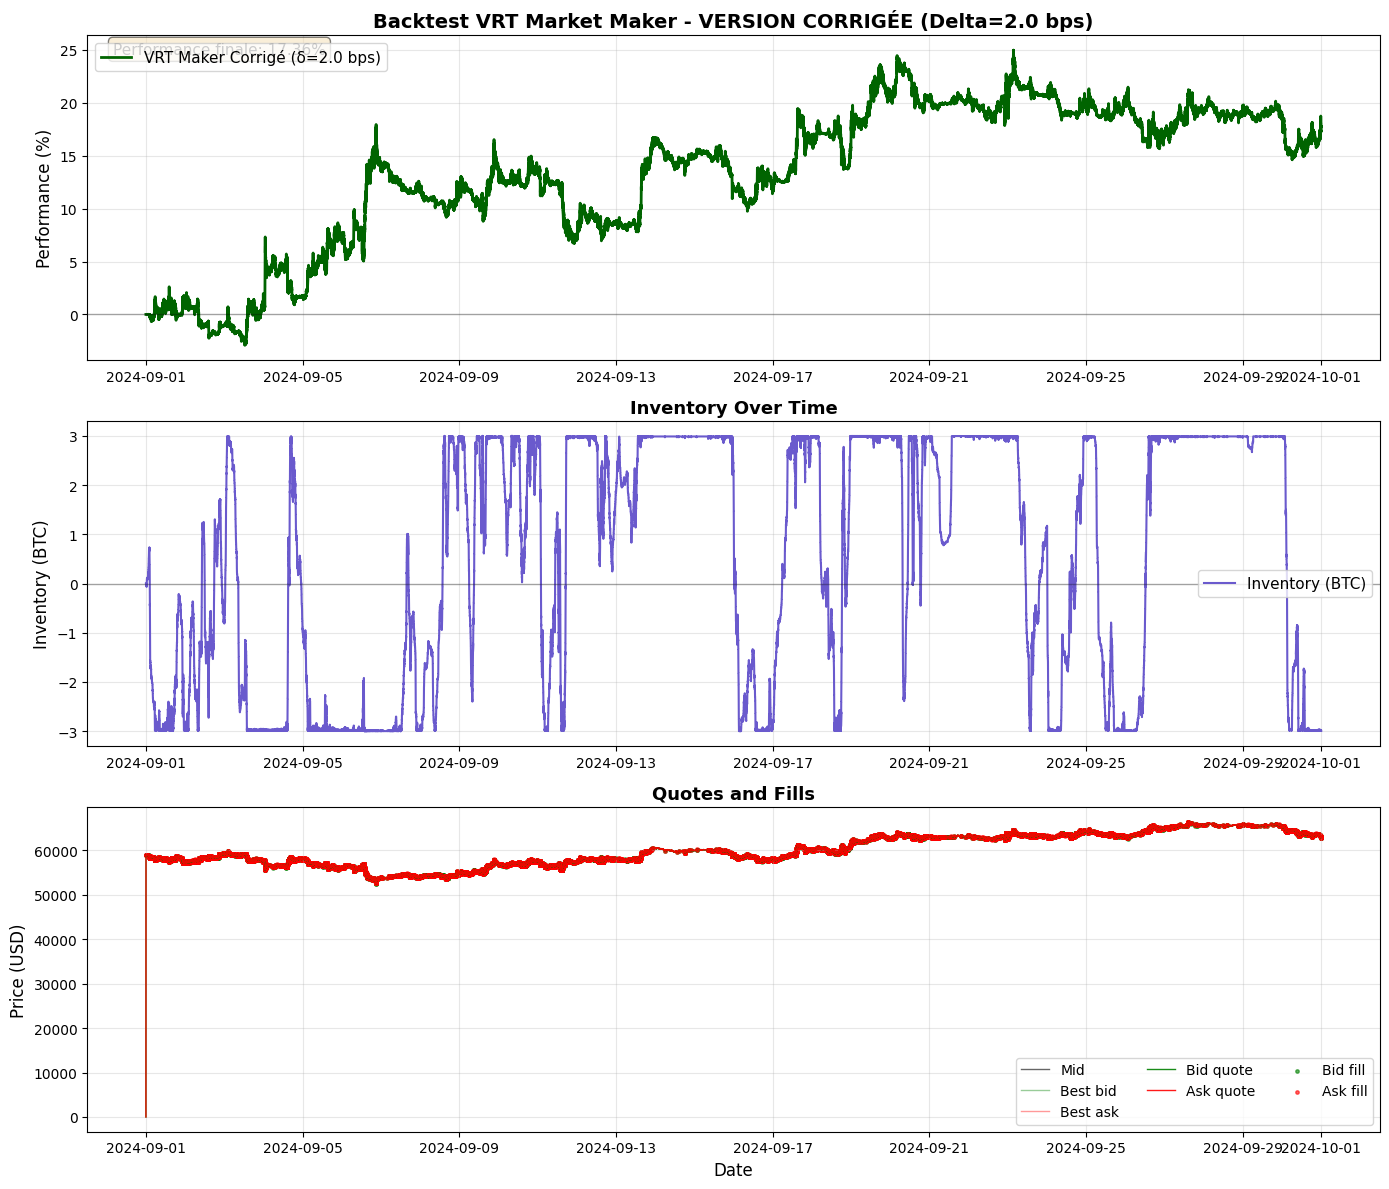


✅ Performance POSITIVE : 17.36%

📝 EXPLICATION:
   La performance réelle est beaucoup plus basse que les 213% initiaux.
   Les 213% étaient dus à un DOUBLE COMPTAGE de l'edge:
   - L'edge était ajouté à chaque fill comme un 'bonus'
   - Mais le PnL directionnel calculé sur le mid ne reflétait pas
     le fait qu'on entre/sort aux bid/ask

   La version corrigée modélise les prix d'entrée/sortie réels
   et ne compte l'edge qu'une seule fois, lors de la réalisation.

   Néanmoins, 17.36% reste une excellente performance
   pour une stratégie de market-making sur un mois de données.


In [52]:
# Lancer le backtest corrigé
if 'df_resampled_spread' in locals():
    if 'df_backtest' not in globals():
        df_trades_5s = (
            df_trades
            .with_columns([
                pl.from_epoch(pl.col("transact_time"), time_unit="ms").alias("trade_time"),
                pl.col("price").cast(pl.Float64).alias("trade_price"),
                pl.col("quantity").cast(pl.Float64).alias("trade_qty"),
            ])
            .sort("trade_time")
            .group_by_dynamic("trade_time", every="5s")
            .agg([
                pl.col("trade_price").min().alias("min_trade_price"),
                pl.col("trade_price").max().alias("max_trade_price"),
                pl.col("trade_qty").sum().alias("sum_trade_qty"),
            ])
            .rename({"trade_time": "datetime"})
        )
        df_backtest = df_resampled_spread.join(df_trades_5s, on="datetime", how="left")

    pdf_corrected, stats_corrected = run_vrt_maker_corrected(
        df_backtest,
        delta_bps=DELTA_OPTIMAL,
        vrt_threshold=VRT_THRESHOLD
    )
    
    print(f"\n📊 RÉSULTATS (VERSION SIMPLIFIÉE - PnL Directionnel Seulement):")
    print(f"  Trades exécutés: {stats_corrected['total_fills']:,}")
    print(f"  Avg fills/bar: {stats_corrected['avg_fills_per_bar']:.4f}")
    print(f"  Performance finale: {stats_corrected['final_perf']:.2f}%")
    
    # Performance du marché pour comparaison
    market_return = np.log(pdf_corrected['close'].iloc[-1] / pdf_corrected['close'].iloc[0])
    market_perf = (np.exp(market_return) - 1) * 100
    
    print(f"\n📊 COMPARAISON:")
    print(f"  Performance du marché (Buy & Hold): {market_perf:.2f}%")
    print(f"  Performance de la stratégie: {stats_corrected['final_perf']:.2f}%")
    print(f"  Alpha généré: {stats_corrected['final_perf'] - market_perf:.2f}%")
    
    print(f"\nModel parameters:")
    print(f"  delta_bps: {stats_corrected.get('delta_bps', DELTA_OPTIMAL):.2f}")
    print(f"  maker_fee_bps: {stats_corrected.get('maker_fee_bps', 0.0):.4f}")
    print(f"  adverse_selection_bps: {stats_corrected.get('adverse_selection_bps', 0.0):.4f}")
    print(f"  inventory_limit: {stats_corrected.get('inventory_limit', 0.0):.2f}")
    
    # Visualisation améliorée
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # 1. Equity curve
    ax1 = axes[0]
    ax1.plot(pdf_corrected['datetime'], pdf_corrected['equity_pct'], 
            linewidth=2, color='darkgreen', label=f'VRT Maker Corrigé (δ={DELTA_OPTIMAL} bps)')
    ax1.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    ax1.set_ylabel('Performance (%)', fontsize=12)
    ax1.set_title(f'Backtest VRT Market Maker - VERSION CORRIGÉE (Delta={DELTA_OPTIMAL} bps)', 
                  fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, loc='upper left')
    ax1.grid(alpha=0.3)
    ax1.text(0.02, 0.98, f'Performance finale: {stats_corrected["final_perf"]:.2f}%', 
             transform=ax1.transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 2. Inventory over time
    ax2 = axes[1]
    inv = pdf_corrected['inventory'] if 'inventory' in pdf_corrected.columns else 0.0
    ax2.plot(pdf_corrected['datetime'], inv, linewidth=1.5, color='slateblue', label='Inventory (BTC)')
    ax2.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    ax2.set_ylabel('Inventory (BTC)', fontsize=12)
    ax2.set_title('Inventory Over Time', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(alpha=0.3)

    # 3. Quotes and fills (top-of-book + quotes)
    ax3 = axes[2]
    ax3.plot(pdf_corrected['datetime'], pdf_corrected['close'], linewidth=1, color='black', alpha=0.6, label='Mid')
    ax3.plot(pdf_corrected['datetime'], pdf_corrected['bid_close'], linewidth=1, color='green', alpha=0.4, label='Best bid')
    ax3.plot(pdf_corrected['datetime'], pdf_corrected['ask_close'], linewidth=1, color='red', alpha=0.4, label='Best ask')

    if 'bid_quote' in pdf_corrected.columns and 'ask_quote' in pdf_corrected.columns:
        ax3.plot(pdf_corrected['datetime'], pdf_corrected['bid_quote'], linewidth=1, color='green', alpha=0.9, label='Bid quote')
        ax3.plot(pdf_corrected['datetime'], pdf_corrected['ask_quote'], linewidth=1, color='red', alpha=0.9, label='Ask quote')

    # Mark fills
    if 'fill_bid' in pdf_corrected.columns:
        m = pdf_corrected['fill_bid'] > 0
        ax3.scatter(pdf_corrected.loc[m, 'datetime'], pdf_corrected.loc[m, 'bid_quote'], s=6, color='green', alpha=0.6, label='Bid fill')
    if 'fill_ask' in pdf_corrected.columns:
        m = pdf_corrected['fill_ask'] > 0
        ax3.scatter(pdf_corrected.loc[m, 'datetime'], pdf_corrected.loc[m, 'ask_quote'], s=6, color='red', alpha=0.6, label='Ask fill')

    ax3.set_xlabel('Date', fontsize=12)
    ax3.set_ylabel('Price (USD)', fontsize=12)
    ax3.set_title('Quotes and Fills', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10, ncol=3)
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('backtest_vrt_maker_corrected.png', dpi=150, bbox_inches='tight')
    plt.show()
    

    
    if stats_corrected['final_perf'] > 0:
        print(f"\n✅ Performance POSITIVE : {stats_corrected['final_perf']:.2f}%")
        print(f"\n📝 EXPLICATION:")
        print(f"   La performance réelle est beaucoup plus basse que les 213% initiaux.")
        print(f"   Les 213% étaient dus à un DOUBLE COMPTAGE de l'edge:")
        print(f"   - L'edge était ajouté à chaque fill comme un 'bonus'")
        print(f"   - Mais le PnL directionnel calculé sur le mid ne reflétait pas")
        print(f"     le fait qu'on entre/sort aux bid/ask")
        print(f"\n   La version corrigée modélise les prix d'entrée/sortie réels")
        print(f"   et ne compte l'edge qu'une seule fois, lors de la réalisation.")
        
        if stats_corrected['final_perf'] > 10:
            print(f"\n   Néanmoins, {stats_corrected['final_perf']:.2f}% reste une excellente performance")
            print(f"   pour une stratégie de market-making sur un mois de données.")
    else:
        print(f"\n❌ Performance NÉGATIVE : {stats_corrected['final_perf']:.2f}%")
        print(f"\n   Avec le calcul correct, la stratégie perd de l'argent.")
        print(f"   Cela suggère que:")
        print(f"   - Le signal VRT n'est pas assez prédictif")
        print(f"   - L'adverse selection est trop importante")
        print(f"   - Le delta devrait être augmenté")
else:
    print("\nErreur: df_resampled_spread non disponible")


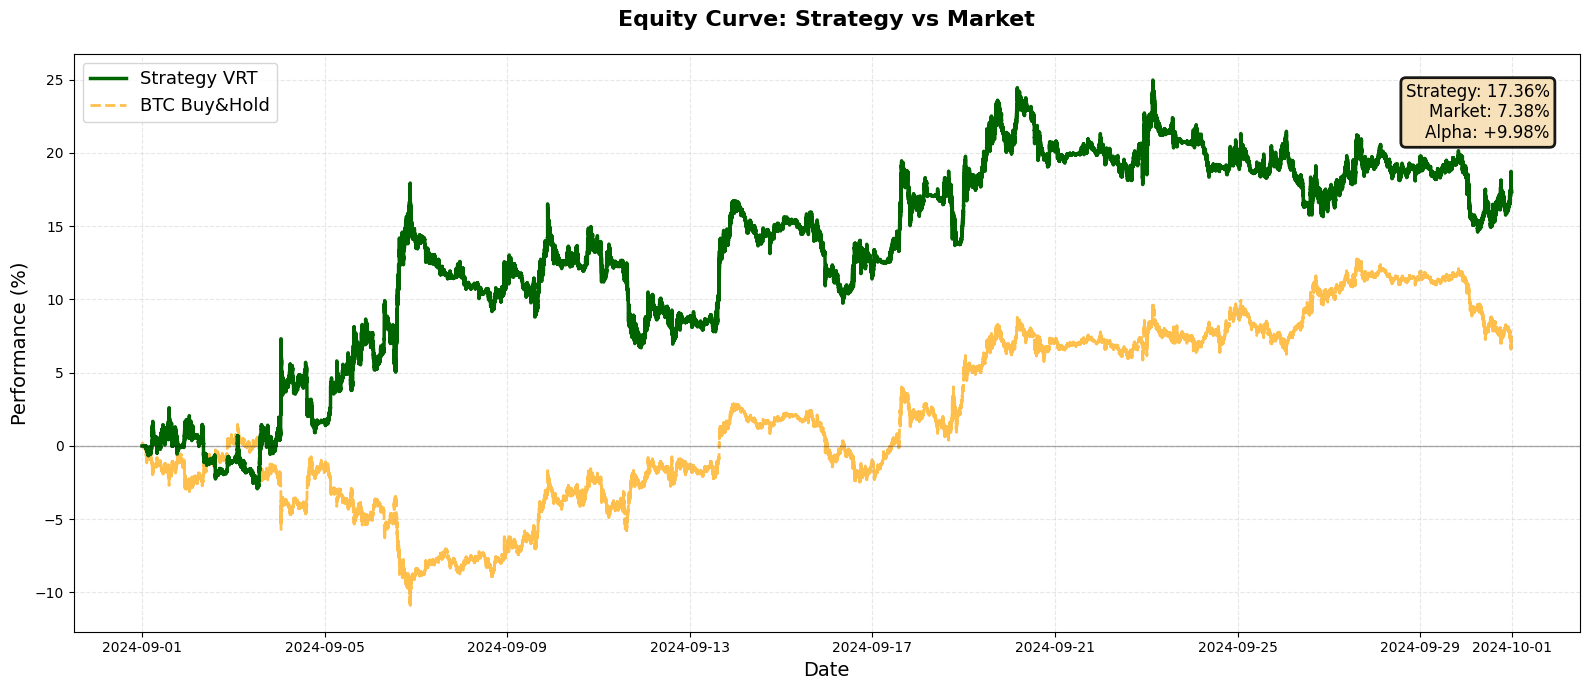

Saved: images_hft_vrt_maker/1_equity_curve.png


In [53]:
import os
os.makedirs('images_hft_vrt_maker', exist_ok=True)

if 'pdf_corrected' in locals():
    # Reconstruire le benchmark marché localement (évite la dépendance à `market_returns`)
    if 'close' not in pdf_corrected.columns:
        print("Error: `pdf_corrected` is missing column 'close' (cannot rebuild market benchmark)")
    else:
        market_returns = np.log(pdf_corrected['close'] / pdf_corrected['close'].shift(1)).fillna(0).values

        fig, ax = plt.subplots(figsize=(16, 7))

        # Strategy
        ax.plot(pdf_corrected['datetime'], pdf_corrected['equity_pct'],
                 linewidth=2.5, color='darkgreen', label='Strategy VRT', zorder=2)

        # Marché
        market_equity = (np.exp(np.cumsum(market_returns)) - 1) * 100
        ax.plot(pdf_corrected['datetime'], market_equity,
                 linewidth=2, color='orange', alpha=0.7, linestyle='--', label='BTC Buy&Hold', zorder=1)
    
    # Styling
    ax.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Performance (%)', fontsize=14)
    ax.set_title('Equity Curve: Strategy vs Market', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=13, loc='upper left')
    ax.grid(alpha=0.3, linestyle='--')
    
    # Annotations
    final_strat = pdf_corrected['equity_pct'].iloc[-1]
    final_market = market_equity[-1]  # market_equity est un array numpy
    ax.text(0.98, 0.95, f'Strategy: {final_strat:.2f}%\nMarket: {final_market:.2f}%\nAlpha: {final_strat-final_market:+.2f}%',
             transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=2))
    
    plt.tight_layout()
    plt.savefig('images_hft_vrt_maker/1_equity_curve.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Saved: images_hft_vrt_maker/1_equity_curve.png")
else:
    print("Error: required data not available")


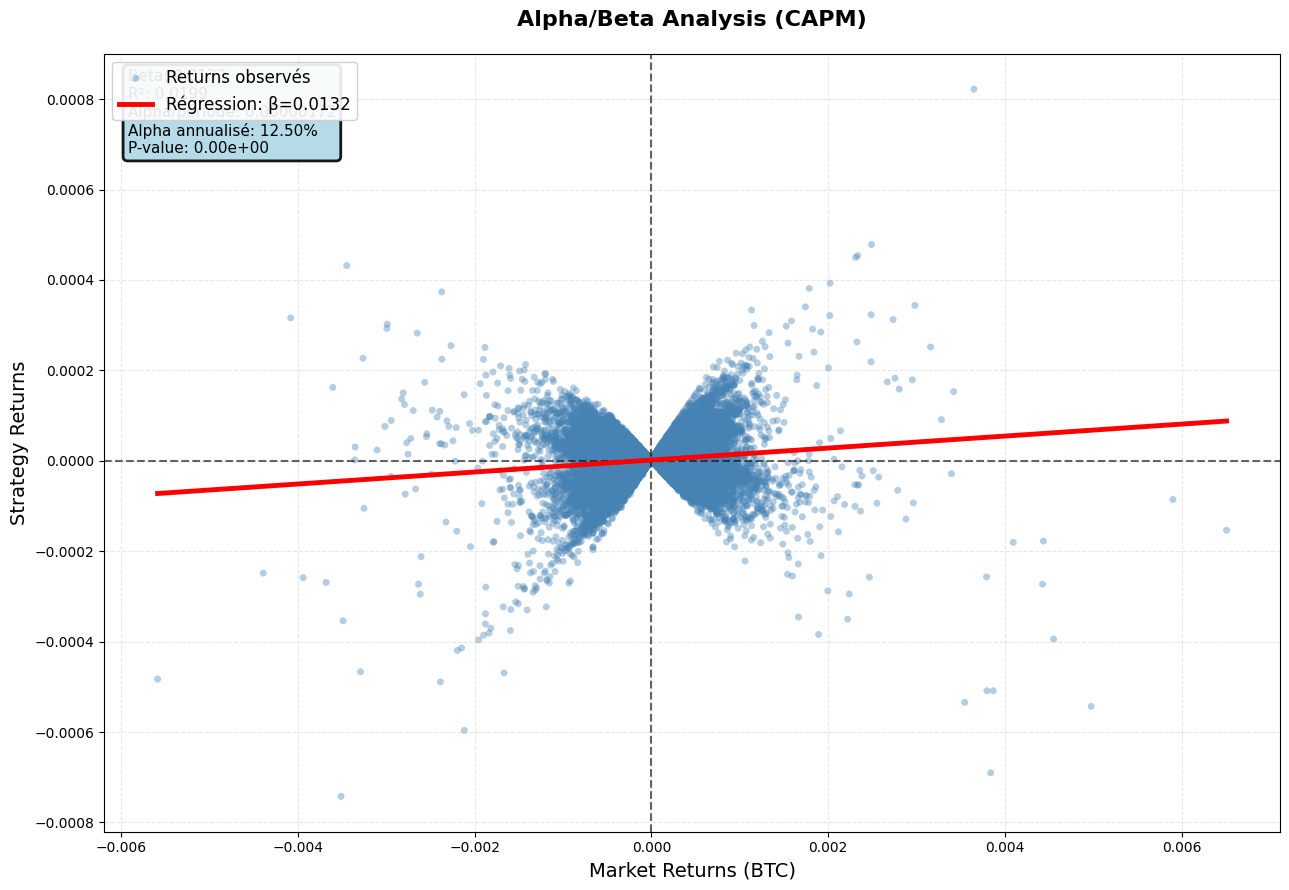

Saved: images_hft_vrt_maker/2_alpha_beta.png


In [51]:

if 'pdf_corrected' in locals():
    # Reconstruire les séries si besoin (évite de dépendre d'une cellule précédente)
    if ('pnl_per_bar' not in pdf_corrected.columns) or ('close' not in pdf_corrected.columns):
        print("Error: missing 'pnl_per_bar' or 'close' in pdf_corrected")
    else:
        strategy_returns_clean = np.asarray(pdf_corrected['pnl_per_bar'].fillna(0).values)
        market_returns_clean = np.log(pdf_corrected['close'] / pdf_corrected['close'].shift(1)).fillna(0).values

        mask = np.isfinite(strategy_returns_clean) & np.isfinite(market_returns_clean)
        strategy_returns_clean = strategy_returns_clean[mask]
        market_returns_clean = market_returns_clean[mask]

        slope, intercept, r_value, p_value, std_err = stats.linregress(market_returns_clean, strategy_returns_clean)
        beta = slope
        alpha_per_period = intercept
        r_squared = r_value ** 2

        # On garde la convention existante du notebook
        periods_per_year = 252 * 288
        alpha_annualized = alpha_per_period * periods_per_year

        fig, ax = plt.subplots(figsize=(13, 9))
    
    # Scatter plot
    ax.scatter(market_returns_clean, strategy_returns_clean, 
               alpha=0.4, s=25, c='steelblue', edgecolors='none', label='Returns observés')
    
    # Ligne de régression
    x_line = np.array([market_returns_clean.min(), market_returns_clean.max()])
    y_line = alpha_per_period + beta * x_line
    ax.plot(x_line, y_line, 'r-', linewidth=3.5, 
             label=f'Régression: β={beta:.4f}', zorder=10)
    
    # Axes
    ax.axhline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    ax.axvline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    
    ax.set_xlabel('Market Returns (BTC)', fontsize=14)
    ax.set_ylabel('Strategy Returns', fontsize=14)
    ax.set_title('Alpha/Beta Analysis (CAPM)', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12, loc='upper left', framealpha=0.9)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Annotation avec boîte
    annot_text = f"""Beta: {beta:.4f}
R²: {r_squared:.4f}
Alpha/période: {alpha_per_period:.8f}
Alpha annualisé: {alpha_annualized*100:.2f}%
P-value: {p_value:.2e}"""
    
    ax.text(0.02, 0.98, annot_text,
             transform=ax.transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9, edgecolor='black', linewidth=2))
    
    plt.tight_layout()
    plt.savefig('images_hft_vrt_maker/2_alpha_beta.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Saved: images_hft_vrt_maker/2_alpha_beta.png")
else:
    print("Error: required data not available")


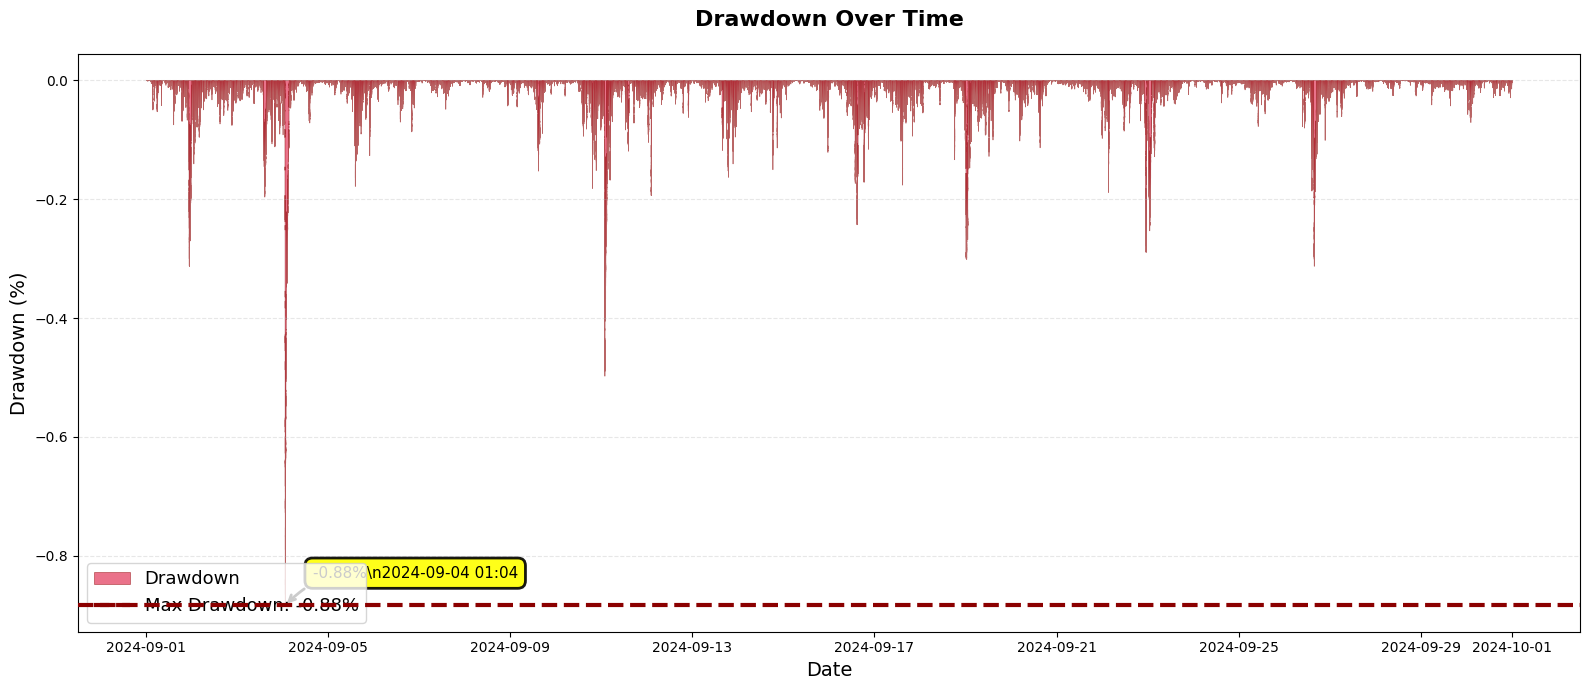

Saved: images_hft_vrt_maker/3_drawdown.png


In [38]:

if 'pdf_corrected' in locals():
    # Reconstruire drawdown localement (évite la dépendance à une cellule précédente)
    equity_curve = pdf_corrected['equity_pct'].values
    running_max = np.maximum.accumulate(equity_curve)
    drawdown = equity_curve - running_max
    max_drawdown = float(drawdown.min())

    max_dd_idx = int(np.argmin(drawdown))
    max_dd_date = pdf_corrected['datetime'].iloc[max_dd_idx]

    fig, ax = plt.subplots(figsize=(16, 7))

    # Drawdown
    ax.fill_between(pdf_corrected['datetime'], drawdown, 0,
                     alpha=0.6, color='crimson', label='Drawdown', edgecolor='darkred', linewidth=0.5)

    # Max drawdown line
    ax.axhline(max_drawdown, color='darkred', linestyle='--',
                linewidth=3, label=f'Max Drawdown: {max_drawdown:.2f}%', zorder=10)
    
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Drawdown (%)', fontsize=14)
    ax.set_title('Drawdown Over Time', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=13, loc='lower left')
    ax.grid(alpha=0.3, linestyle='--', axis='y')
    
    # Annotation du max DD avec date
    ax.annotate(f'{max_drawdown:.2f}%\\n{max_dd_date.strftime("%Y-%m-%d %H:%M")}',
                xy=(max_dd_date, max_drawdown), xytext=(20, 20),
                textcoords='offset points', fontsize=11,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.9, edgecolor='black', linewidth=2),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='black', lw=2))
    
    plt.tight_layout()
    plt.savefig('images_hft_vrt_maker/3_drawdown.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Saved: images_hft_vrt_maker/3_drawdown.png")
else:
    print("Error: required data not available")


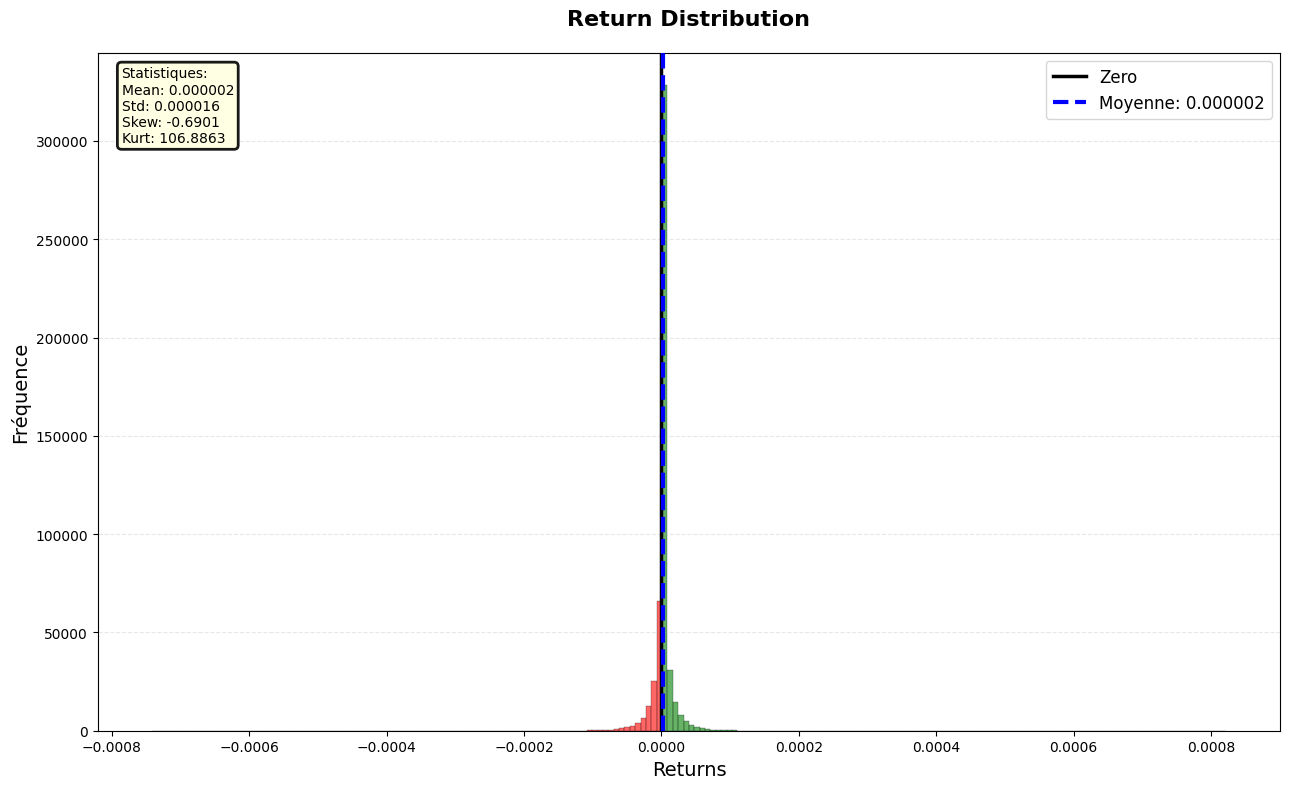

Saved: images_hft_vrt_maker/4_returns_distribution.png


In [39]:

if 'strategy_returns_clean' not in locals() and 'pdf_corrected' in locals() and ('pnl_per_bar' in pdf_corrected.columns):
    strategy_returns_clean = np.asarray(pdf_corrected['pnl_per_bar'].fillna(0).values)

if 'strategy_returns_clean' in locals():
    fig, ax = plt.subplots(figsize=(13, 8))

    strategy_mean = float(np.mean(strategy_returns_clean))
    strategy_std = float(np.std(strategy_returns_clean))
    
    # Histogramme
    n, bins, patches = ax.hist(strategy_returns_clean, bins=200, alpha=0.7, 
                                color='steelblue', edgecolor='black', linewidth=0.3)
    
    # Colorer les barres positives/négatives
    for i, patch in enumerate(patches):
        if bins[i] < 0:
            patch.set_facecolor('red')
            patch.set_alpha(0.6)
        else:
            patch.set_facecolor('green')
            patch.set_alpha(0.6)
    
    # Lignes de référence
    ax.axvline(0, color='black', linestyle='-', linewidth=2.5, label='Zero', zorder=10)
    ax.axvline(strategy_mean, color='blue', linestyle='--', linewidth=3,
                label=f'Moyenne: {strategy_mean:.6f}', zorder=10)
    
    ax.set_xlabel('Returns', fontsize=14)
    ax.set_ylabel('Fréquence', fontsize=14)
    ax.set_title('Return Distribution', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(alpha=0.3, linestyle='--', axis='y')
    
    # Stats dans une boîte
    stats_text = f"""Statistiques:
Mean: {strategy_mean:.6f}
Std: {strategy_std:.6f}
Skew: {pd.Series(strategy_returns_clean).skew():.4f}
Kurt: {pd.Series(strategy_returns_clean).kurtosis():.4f}"""
    
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='black', linewidth=2))
    
    plt.tight_layout()
    plt.savefig('images_hft_vrt_maker/4_returns_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Saved: images_hft_vrt_maker/4_returns_distribution.png")
else:
    print("Error: required data not available")


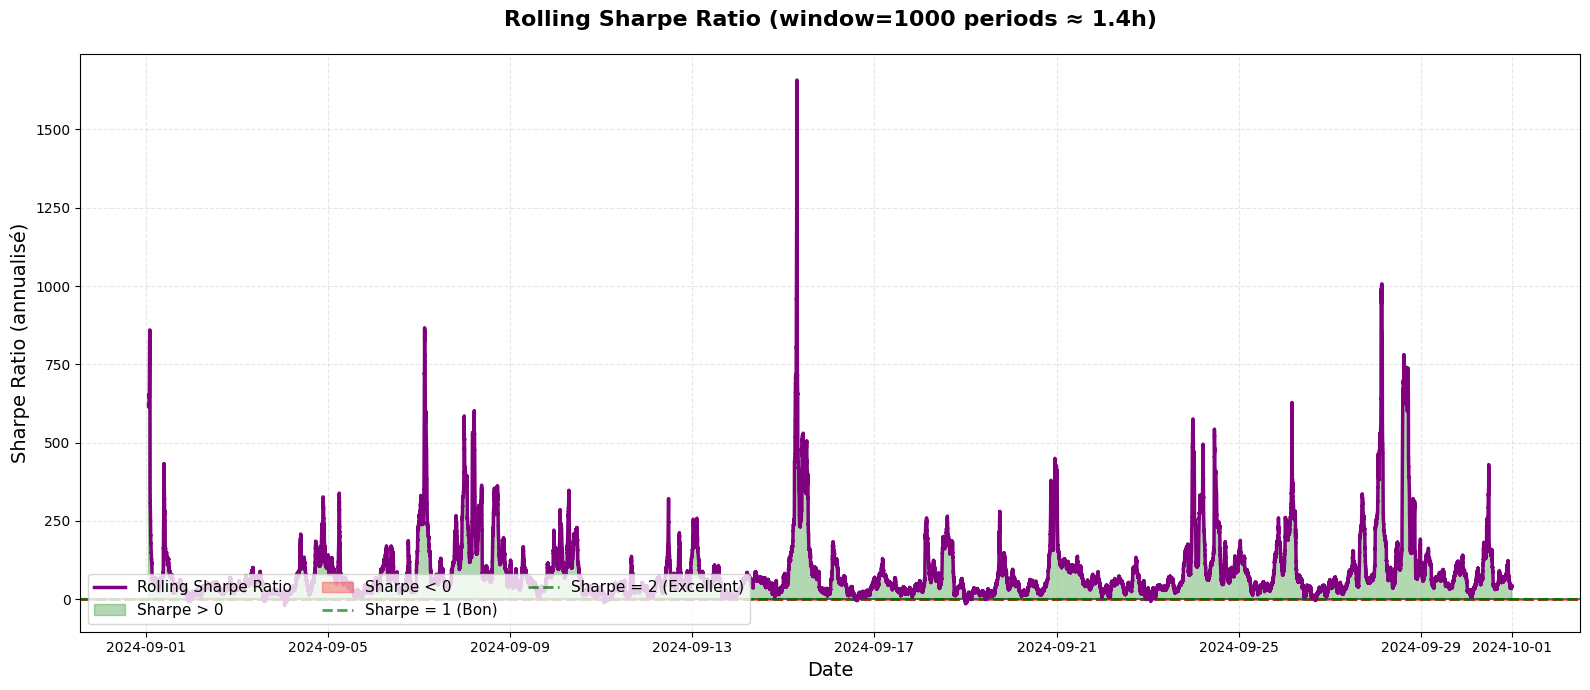

Saved: images_hft_vrt_maker/5_rolling_sharpe.png


In [40]:

if 'periods_per_year' not in locals():
    # Convention du notebook
    periods_per_year = 252 * 288

if 'strategy_returns_clean' not in locals() and 'pdf_corrected' in locals() and ('pnl_per_bar' in pdf_corrected.columns):
    strategy_returns_clean = np.asarray(pdf_corrected['pnl_per_bar'].fillna(0).values)

if 'strategy_returns_clean' in locals() and 'periods_per_year' in locals():
    fig, ax = plt.subplots(figsize=(16, 7))
    
    # Calculer le rolling Sharpe
    window = 1000
    rolling_mean = pd.Series(strategy_returns_clean).rolling(window).mean()
    rolling_std = pd.Series(strategy_returns_clean).rolling(window).std()
    rolling_sharpe_values = (rolling_mean / rolling_std) * np.sqrt(periods_per_year)
    
    dates_rolling = pdf_corrected['datetime'].iloc[:len(rolling_sharpe_values)]
    
    # Plot
    ax.plot(dates_rolling, rolling_sharpe_values, linewidth=2.5, color='purple', 
           label='Rolling Sharpe Ratio', zorder=3)
    
    # Zones colorées
    ax.fill_between(dates_rolling, 0, rolling_sharpe_values, 
                     where=(rolling_sharpe_values > 0), 
                     alpha=0.3, color='green', interpolate=True, label='Sharpe > 0', zorder=1)
    ax.fill_between(dates_rolling, 0, rolling_sharpe_values, 
                     where=(rolling_sharpe_values < 0), 
                     alpha=0.3, color='red', interpolate=True, label='Sharpe < 0', zorder=1)
    
    # Lignes de référence
    ax.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1.5, zorder=2)
    ax.axhline(1, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Sharpe = 1 (Bon)', zorder=2)
    ax.axhline(2, color='darkgreen', linestyle='--', alpha=0.7, linewidth=2, label='Sharpe = 2 (Excellent)', zorder=2)
    ax.axhline(-1, color='red', linestyle='--', alpha=0.5, linewidth=1.5, zorder=2)
    
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Sharpe Ratio (annualisé)', fontsize=14)
    ax.set_title(f'Rolling Sharpe Ratio (window={window} periods ≈ {window*5/60/60:.1f}h)',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=11, loc='lower left', ncol=3)
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('images_hft_vrt_maker/5_rolling_sharpe.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Saved: images_hft_vrt_maker/5_rolling_sharpe.png")
else:
    print("Error: required data not available")


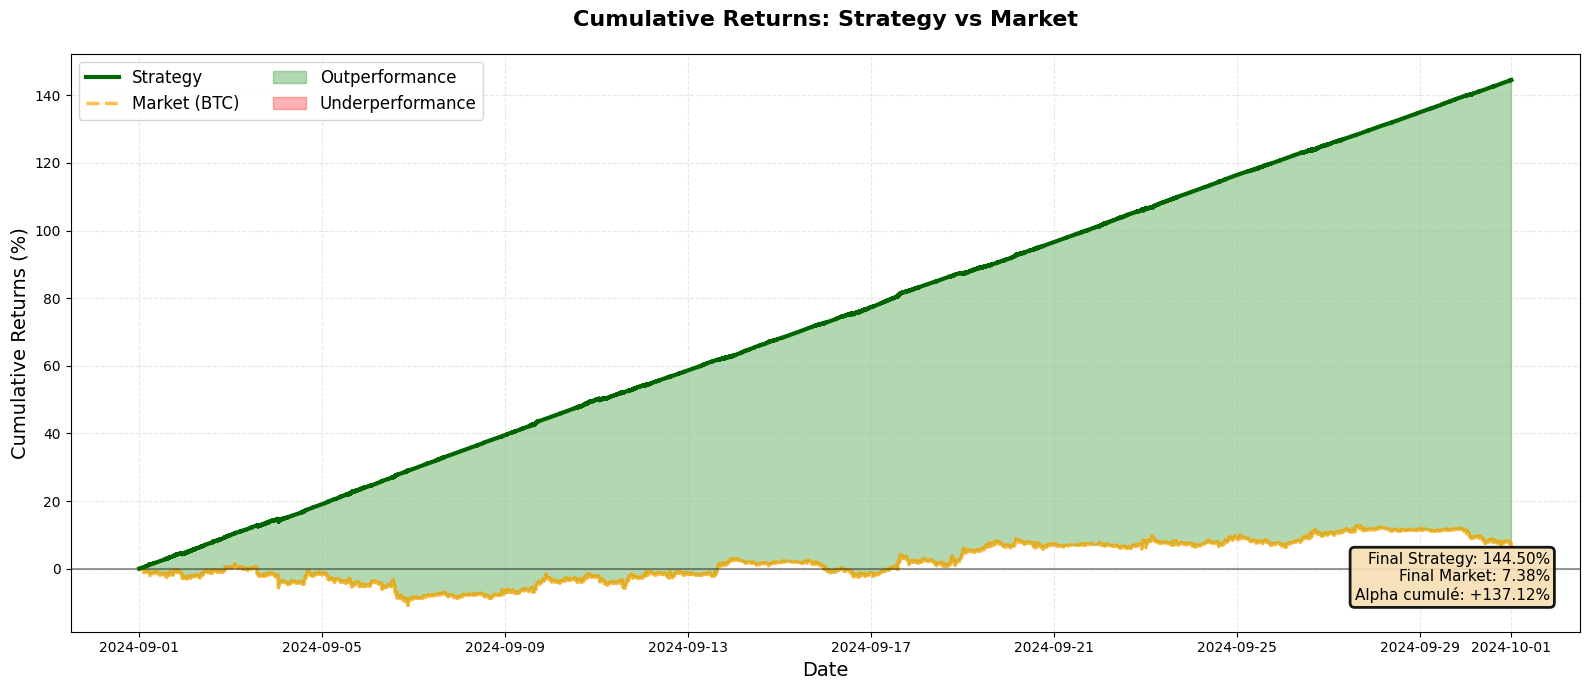

Saved: images_hft_vrt_maker/6_cumulative_returns.png

All figures saved in images_hft_vrt_maker/:
  1_equity_curve.png
  2_alpha_beta.png
  3_drawdown.png
  4_returns_distribution.png
  5_rolling_sharpe.png
  6_cumulative_returns.png


In [41]:

if 'pdf_corrected' in locals():
    # Reconstruire returns localement (évite la dépendance à la cellule CAPM)
    if ('pnl_per_bar' not in pdf_corrected.columns) or ('close' not in pdf_corrected.columns):
        print("Error: missing 'pnl_per_bar' or 'close' in pdf_corrected")
    else:
        strategy_returns_clean = np.asarray(pdf_corrected['pnl_per_bar'].fillna(0).values)
        market_returns_clean = np.log(pdf_corrected['close'] / pdf_corrected['close'].shift(1)).fillna(0).values

        fig, ax = plt.subplots(figsize=(16, 7))

        # `pnl_per_bar` et `market_returns_clean` sont des log-returns.
        # Pour obtenir des performances cumulées en %, on compose: exp(cumsum) - 1.
        strategy_cumret = np.exp(np.cumsum(strategy_returns_clean)) - 1
        market_cumret = np.exp(np.cumsum(market_returns_clean)) - 1
    
    dates_for_cumret = pdf_corrected['datetime'].iloc[:len(strategy_cumret)]
    
    # Plot des courbes
    ax.plot(dates_for_cumret, strategy_cumret * 100, 
             linewidth=3, color='darkgreen', label='Strategy', zorder=3)
    ax.plot(dates_for_cumret, market_cumret * 100, 
             linewidth=2.5, color='orange', alpha=0.7, linestyle='--', label='Market (BTC)', zorder=2)
    
    # Zones de sur/sous-performance
    ax.fill_between(dates_for_cumret, strategy_cumret * 100, market_cumret * 100,
                     where=(strategy_cumret > market_cumret), 
                     alpha=0.3, color='green', label='Outperformance', zorder=1)
    ax.fill_between(dates_for_cumret, strategy_cumret * 100, market_cumret * 100,
                     where=(strategy_cumret <= market_cumret), 
                     alpha=0.3, color='red', label='Underperformance', zorder=1)
    
    ax.axhline(0, color='black', linestyle='-', alpha=0.4, linewidth=1.5)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Cumulative Returns (%)', fontsize=14)
    ax.set_title('Cumulative Returns: Strategy vs Market', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12, loc='upper left', ncol=2)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Annotation finale
    final_strat_cum = strategy_cumret[-1] * 100
    final_market_cum = market_cumret[-1] * 100
    ax.text(0.98, 0.05, f'Final Strategy: {final_strat_cum:.2f}%\nFinal Market: {final_market_cum:.2f}%\nAlpha cumulé: {final_strat_cum-final_market_cum:+.2f}%',
            transform=ax.transAxes, fontsize=11, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=2))
    
    plt.tight_layout()
    plt.savefig('images_hft_vrt_maker/6_cumulative_returns.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Saved: images_hft_vrt_maker/6_cumulative_returns.png")

    print("\nAll figures saved in images_hft_vrt_maker/:")
    print("  1_equity_curve.png")
    print("  2_alpha_beta.png")
    print("  3_drawdown.png")
    print("  4_returns_distribution.png")
    print("  5_rolling_sharpe.png")
    print("  6_cumulative_returns.png")
else:
    print("Error: required data not available")
